# Spark 推荐系统
使用MovieLens数据集训练协同过滤模型

## 1. 数据集下载
数据集下载较慢，选择下载5M数据

190M http://files.grouplens.org/datasets/movielens/ml-20m.zip 

5M http://files.grouplens.org/datasets/movielens/ml-100k.zip 

## 2. 对数据进行探索

MovieLens 100k数据集包含了表示多个用户对多部电影的10次评级数据，也包含了电影元数据和用户属性数据

对ml-100k.zip解压缩后，有几个重要的文件

- u.user 包含了user id, age, gender, occupation和ZIP
- u.item 包含了movie id, title, realease date以及若干与IMDB link和电影分类相关的属性
- u.data 包含了user id, movie id, rating (从1到5)和timestamp的属性

### 2.1 探索用户数据

In [2]:
# Creating a SparkSession in Python
from pyspark.sql import SparkSession
# getOrCreate()如果存在则获取，如果不存在则创建
session = SparkSession.builder.master("local").appName("Spark ALS").getOrCreate()
sc = session.sparkContext

In [3]:
user_data = sc.textFile('./data/ml-100k/u.user')
user_data.first()

'1|24|M|technician|85711'

可以看到是使用|进行分割的

In [4]:
user_fields = user_data.map(lambda line: line.split("|"))
print(user_fields.first())
num_users = user_fields.map(lambda fields: fields[0]).count()
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count()
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()
num_zipcodes = user_fields.map( lambda fields: fields[4]).distinct().count()
print("Users:%d, gender: %d, occcupation:%d, zip code: %d" %(num_users, num_genders, num_occupations,num_zipcodes))

['1', '24', 'M', 'technician', '85711']
Users:943, gender: 2, occcupation:21, zip code: 795


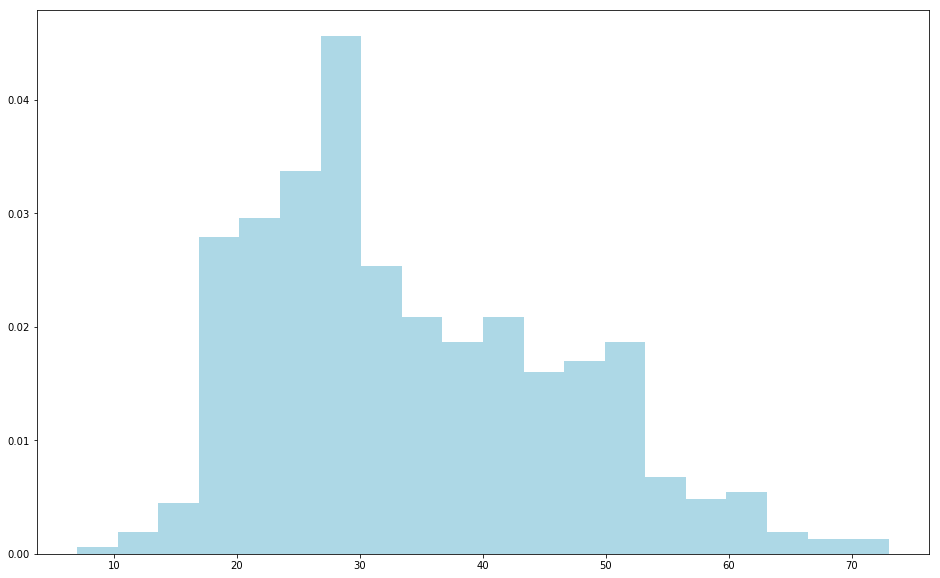

In [12]:
import matplotlib.pyplot as plt
# 获取年龄的直方图
ages = user_fields.map( lambda x: int(x[1])).collect()
plt.hist(ages, bins=20, color='lightblue',normed=True)
fig = plt.gcf()
fig.set_size_inches(16, 10)
# 可以发现年龄比较年轻，25到30之间的用户比较多

[('technician', 27), ('other', 105), ('writer', 45), ('executive', 32), ('administrator', 79)]


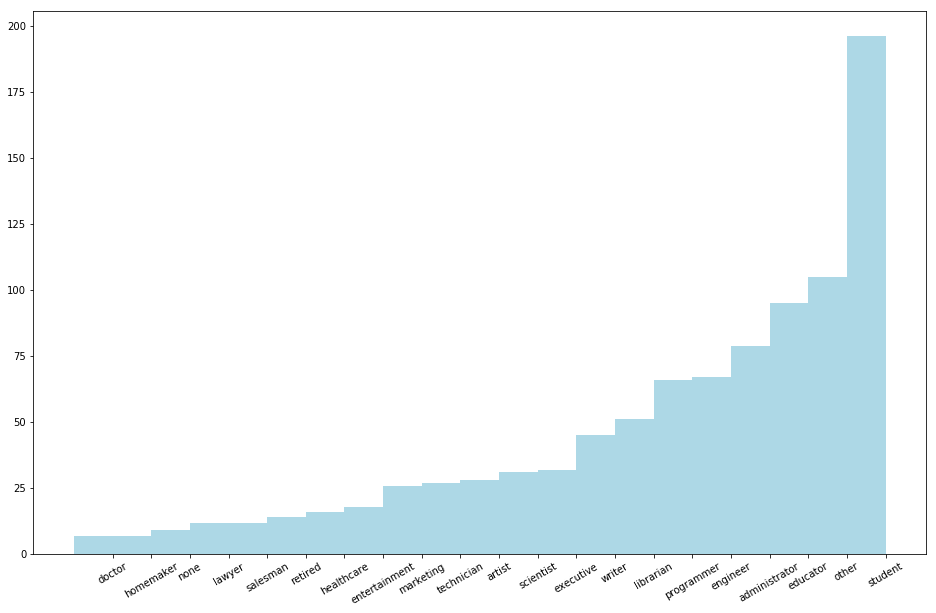

In [13]:
import numpy as np

# 获取职业信息的描述
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
print(count_by_occupation[ :5])
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(16, 10)


职业最多的是student, other, educator, administrator, engineer和programer

### 2.2 探索电影数据

In [14]:
movie_data=sc.textFile('./data/ml-100k/u.item')
print(movie_data.first())
num_movie=movie_data.count()
print("movies: %d" % num_movie)

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
movies: 1682


绘制电影的直方图

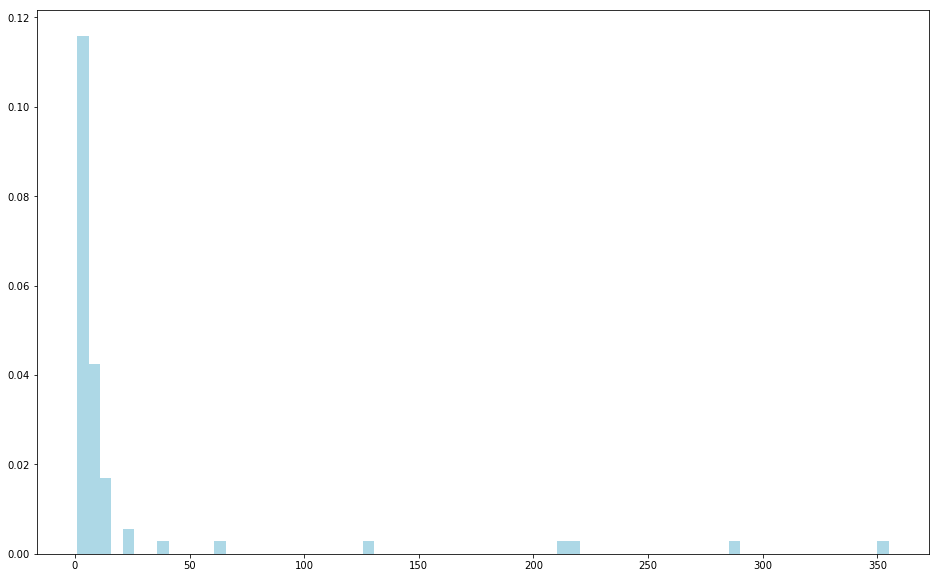

In [15]:
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900

movie_fields = movie_data.map(lambda lines: lines.split("|"))
years = movie_fields.map(lambda fields:fields[2]).map(lambda x: convert_year(x))
# 过滤掉非法数据
years_filtered = years.filter(lambda x: x != 1900)
movie_ages = years_filtered.map( lambda yr: 1998 - yr).countByValue()
values = movie_ages.values()
bins = movie_ages.keys()
plt.hist(values, bins=len(bins), color='lightblue', normed=True)
fig = plt.gcf()
fig.set_size_inches(16,10)

大部分是1998年的电影
### 2.3 探索影评数据

In [16]:
rating_data=sc.textFile('./data/ml-100k/u.data')
print(rating_data.first())
num_ratings=rating_data.count()
print("Ratings: %d" % num_ratings)

196	242	3	881250949
Ratings: 100000


发现是使用\t进行分割的

In [17]:
rating_data=rating_data.map(lambda line: line.split("\t"))
ratings=rating_data.map( lambda fields: int(fields[2]))
# 取出最大评分
max_rating=ratings.reduce( lambda x,y:max(x,y))
# 取出最小评分
min_rating=ratings.reduce( lambda x,y:min(x,y))
# 平均评分
mean_rating=ratings.reduce( lambda x,y: x+y )/num_ratings
# 取中位数
median_rating=np.median(ratings.collect() )
# 取每位用户的评分次数
ratings_per_user=num_ratings/num_users
# 取每部电影的平均分
ratings_per_movie=num_ratings/num_movie


print("Min rating: %d" % min_rating)
print("Max rating: %d" % max_rating)
print("Average rating:%2.2f" % mean_rating)
print("Median rating:%d" % median_rating)
print("Average # of ratings per user:%2.2f" % ratings_per_user)
print("Average # of ratings per movie:%2.2f" % ratings_per_movie)

Min rating: 1
Max rating: 5
Average rating:3.53
Median rating:4
Average # of ratings per user:106.04
Average # of ratings per movie:59.45


In [18]:
# spark对rdd提供的  stats()函数，也可以进行统计. 
ratings.stats()

(count: 100000, mean: 3.529859999999947, stdev: 1.1256679707622548, max: 5.0, min: 1.0)

可以看出，影评的均值是3.5，但是中位数是4，这就说明，影评的分布有些倾向高点的得分

[3 1 2 4 5]


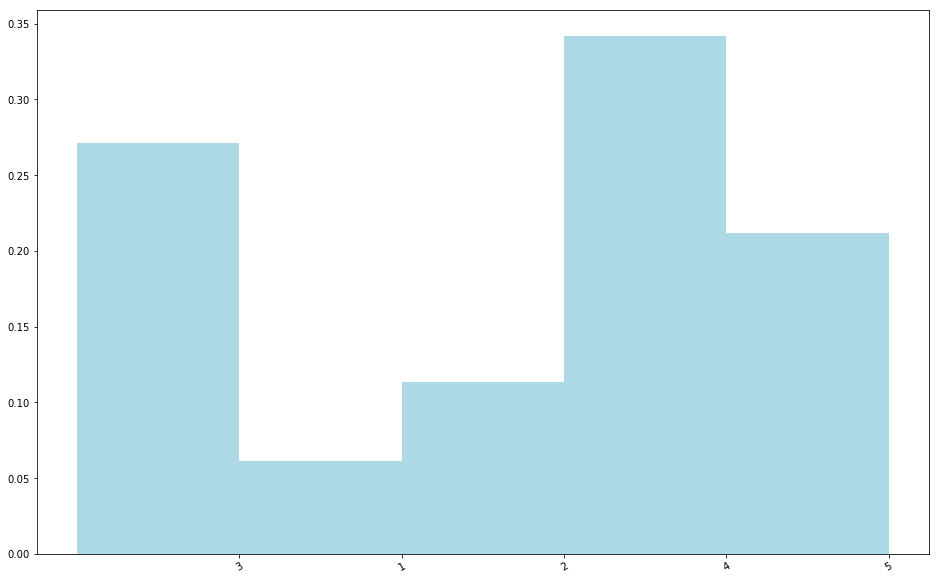

In [19]:
# 生成评级值分布的条形图
count_by_rating = ratings.countByValue() # 求出每个评分的评分次数
x_axis = np.array(list(count_by_rating.keys())) # 以1,2,3,4,5这五个分数做为x坐标
y_axis = np.array([float(c) for c in count_by_rating.values()]) # 求出五个分数每个分类的评分次数形成y轴值
#让y轴正则化，使它表示为百分比
y_axis_normed = y_axis / y_axis.sum()
print(x_axis)

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(16, 10)

[(196, 39), (186, 92), (22, 128), (244, 238), (166, 20)]


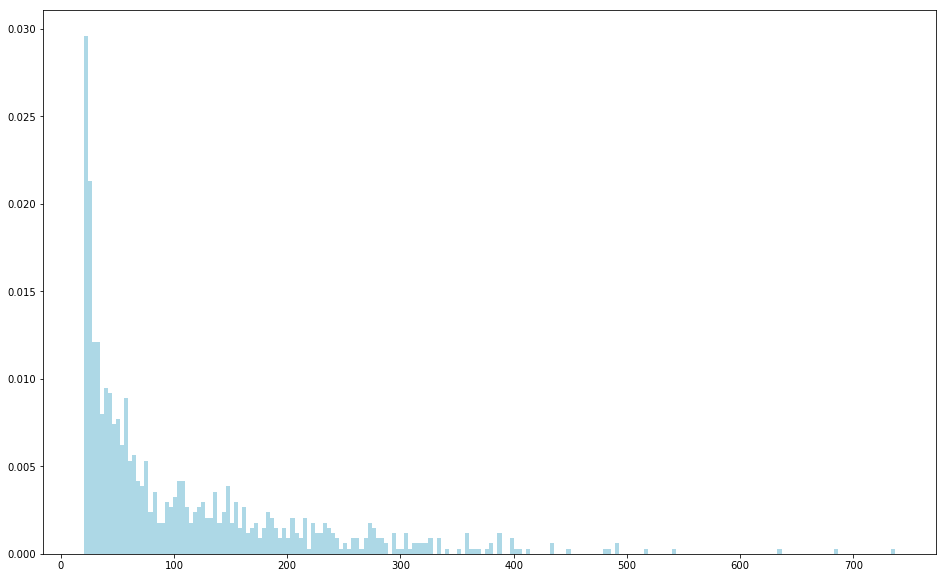

In [20]:
# 对评级以用户id为主键进行分组
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey()
# 求出每一个主键对应的评级集合的大小, 即各用户评级的次数
user_ratings_byuser = user_ratings_grouped.map(lambda x : (x[0], len(x[1])))
# 取前5个用户评级次数查看
print(user_ratings_byuser.take(5))
# 绘制用户评级分布的直方图
# 获取每个用户评价的数目
user_ratings_byuser_local = user_ratings_byuser.map(lambda x: x[1]).collect()
plt.hist(user_ratings_byuser_local, bins=200, color='lightblue', normed=True)
fig = plt.gcf()
fig.set_size_inches(16,10)

## 3. 训练ALS模型

In [23]:
# import module
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Load data
lines = session.read.text('./data/ml-100k/u.data').rdd
# Clean up the data by splitting it
parts = lines.map(lambda row: row.value.split('\t'))
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2]), timestamp=int(p[3])))
ratings = session.createDataFrame(ratingsRDD)
print(ratings.first())
print(ratings.count())

Row(movieId=242, rating=3.0, timestamp=881250949, userId=196)
100000


In [24]:
# create training and test set
train_set, test_set = ratings.randomSplit([0.8, 0.2])

In [25]:
train_set.count()

79962

In [26]:
test_set.count()

20038

In [27]:
# Need to cache the data to speed up training
# train_set.cache()
# test_set.cache()

In [29]:
# Setting up the parameters for ALS
# Latent Factors to be made
# 一般来说越多越好，但是直接影响模型训练和保存时所需要的开销
rank = 5 
# Times to repeat process
# 一般10次左右就挺好，ALS模型一般在少数迭代后，就可以获得一个比较好的模型
numIterations = 10 

# Create the model on the training data
# 设置drop变量为了应对冷启动问题，防止在验证集中出现
als = ALS(rank=5, maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
              coldStartStrategy="drop")

model = als.fit(train_set)

评估模型

In [30]:
predictions = model.transform(test_set)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9979211736946978


输出推荐信息

In [35]:
# 为每个用户推荐10部电影
userRecs = model.recommendForAllUsers(10)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[668, 16.382452]...|
|   463|[[1368, 7.9040647...|
|   833|[[838, 8.235501],...|
|   496|[[1426, 11.372323...|
|   148|[[1264, 8.782997]...|
|   540|[[1628, 6.8414593...|
|   392|[[1368, 7.5529375...|
|   243|[[838, 6.695163],...|
|   623|[[1643, 7.091775]...|
|   737|[[1402, 8.396091]...|
|   897|[[1628, 7.843519]...|
|   858|[[838, 8.6568165]...|
|    31|[[1402, 10.471441...|
|   516|[[1643, 7.952296]...|
|   580|[[1426, 8.474022]...|
|   251|[[1643, 6.8520784...|
|   451|[[867, 10.538914]...|
|    85|[[1643, 5.87232],...|
|   137|[[1154, 10.643098...|
|   808|[[838, 8.511277],...|
+------+--------------------+
only showing top 20 rows



In [36]:
# 为每一部电影找到最适合的10个人
movieRecs = model.recommendForAllItems(10)
movieRecs.show()


+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|   1580|[[688, 2.2965343]...|
|    471|[[688, 5.671004],...|
|   1591|[[427, 6.221892],...|
|   1342|[[34, 5.801315], ...|
|    463|[[762, 7.4802117]...|
|    833|[[928, 6.421313],...|
|   1645|[[4, 7.0040956], ...|
|    496|[[762, 7.3872967]...|
|    148|[[127, 6.0661926]...|
|   1088|[[471, 10.178247]...|
|   1238|[[471, 7.647541],...|
|    540|[[212, 5.388003],...|
|   1460|[[762, 5.4682417]...|
|    392|[[212, 6.9279137]...|
|   1522|[[519, 5.495287],...|
|    243|[[739, 5.9008455]...|
|    623|[[212, 6.596528],...|
|   1483|[[127, 8.311581],...|
|   1084|[[427, 7.726925],...|
|   1025|[[739, 6.6779976]...|
+-------+--------------------+
only showing top 20 rows



In [37]:
# 给指定用户推荐10部电影
users = ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)
userSubsetRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    26|[[1628, 6.0987415...|
|   474|[[1628, 7.430438]...|
|    29|[[838, 8.251592],...|
+------+--------------------+



In [39]:
# 给指定的电影，推荐10个用户
movies = ratings.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 10)
movieSubSetRecs.show()

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|     26|[[688, 5.852412],...|
|    474|[[857, 7.394747],...|
|     29|[[471, 6.9561176]...|
+-------+--------------------+



In [40]:
session.stop()